In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from importlib.util import find_spec
if find_spec("qml_hep_lhc") is None:
    import sys
    sys.path.append('..')

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq

from qml_hep_lhc.data.electron_photon import ElectronPhoton
import argparse

2022-07-06 16:05:17.473459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 16:05:17.473547: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-06 16:05:59.656139: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-06 16:05:59.656259: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bhagvada): /proc/driver/nvidia/version does not exist
2022-07-06 16:05:59.687032: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
T

In [3]:
from numba import cuda, njit, prange
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from numba import njit, prange

In [45]:
n = 32
N = n**2
a = np.zeros((N, N))
sigma = 0.95*np.pi

@njit(parallel=True)
def fun(a,i):
    for j in prange(i,N):
        p1 = np.array([i//n, i%n])
        p2 = np.array([j//n, j%n])
        d = np.sqrt(np.sum(np.square(p1 - p2)))
        val = np.exp(-d/(sigma**2))
        a[i][j] = val
        a[j][i] = val


def fun_1(a):
    for i in prange(N):
        fun(a,i)
s = time.time()
fun_1(a)
e = time.time()
    
print(e - s)

0.8633432388305664


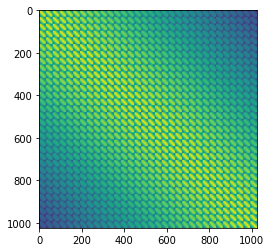

In [42]:
plt.imshow(np.log10(a))

In [7]:
cuda.is_available()

False

In [21]:
# Works only when image size is a power of 2
threads = 16
n = 32
N = n**2
sigma = np.pi
blocks = (N + threads - 1)//threads
BLOCKS = (blocks, blocks)
THREADS = (threads, threads)

a_d = cuda.device_array(shape=(N,N), dtype=np.float32)
@cuda.jit
def graph(a_d, sigma):
    by =  cuda.blockIdx.y
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    tx = cuda.threadIdx.x
    dim = cuda.blockDim.x
    tiles = (N+dim-1)//dim
    
    i = by*dim + ty
    j = bx*dim + tx
    d = math.sqrt((i//n-j//n)**2 + (i%n - j%n)**2)
    val = math.exp(-d/(sigma**2))
#     d = np.sqrt(np.sum(np.square(p1 - p2)))
#     val = np.exp(-d)/sigma
    a_d[i][j] = val
    
    cuda.syncthreads()

%time graph[BLOCKS, THREADS](a_d, sigma); cuda.synchronize()
a = a_d.copy_to_host()

CudaSupportError: Error at driver init: Call to cuInit results in CUDA_ERROR_NO_DEVICE (100)

In [4]:
args = argparse.Namespace()

args.graph_conv = True
args.dataset_type = "med"
args.percent_samples = 0.1
# args.quantum = True
# args.pca = 16
# args.normalize = True
# args.threshold = 0
# args.loss = "Hinge"
# args.hinge_labels = True
# args.angle_encoding = True

In [5]:
data = ElectronPhoton(args)
data.prepare_data()
data.setup()

None
/home/gopald/Documents/qml-hep-lhc/datasets/downloaded
/home/gopald/Documents/qml-hep-lhc/datasets/downloaded/electron_photon_med.npz
Performing graph convolution...
(900, 32, 32, 2)
Performing graph convolution...
(100, 32, 32, 2)


In [6]:
data

Dataset :Electron Photon med
╒════════╤══════════════════╤══════════════════╤═════════════╕
│ Data   │ Train size       │ Test size        │ Dims        │
╞════════╪══════════════════╪══════════════════╪═════════════╡
│ X      │ (900, 32, 32, 2) │ (100, 32, 32, 2) │ (32, 32, 2) │
├────────┼──────────────────┼──────────────────┼─────────────┤
│ y      │ (900,)           │ (100,)           │ (1,)        │
╘════════╧══════════════════╧══════════════════╧═════════════╛

Train images stats
Min: -5.34
Max: 8.27
Mean: 0.18
Std: 0.61
Train labels stats
Min: 0.00
Max: 1.00

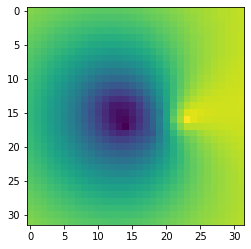

In [12]:
plt.imshow(np.mean(data.x_train[19,:,:,1]))

In [88]:
args = argparse.Namespace()
args.dataset_type = "med"
args.percent_samples = 0.1

data = ElectronPhoton(args)
data.prepare_data()
data.setup()

None
/home/gopald/Documents/qml-hep-lhc/datasets/downloaded
/home/gopald/Documents/qml-hep-lhc/datasets/downloaded/electron_photon_med.npz


In [89]:
data

Dataset :Electron Photon med
╒════════╤══════════════════╤══════════════════╤═════════════╕
│ Data   │ Train size       │ Test size        │ Dims        │
╞════════╪══════════════════╪══════════════════╪═════════════╡
│ X      │ (900, 32, 32, 2) │ (100, 32, 32, 2) │ (32, 32, 2) │
├────────┼──────────────────┼──────────────────┼─────────────┤
│ y      │ (900,)           │ (100,)           │ (1,)        │
╘════════╧══════════════════╧══════════════════╧═════════════╛

Train images stats
Min: -2.43
Max: 2.22
Mean: 0.00
Std: 0.05
Train labels stats
Min: 0.00
Max: 1.00

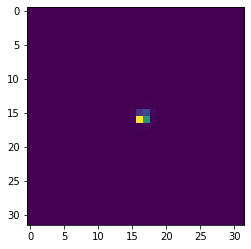

In [90]:
plt.imshow(data.x_train[15,:,:,0])

In [77]:
A = np.random.randint(0, 10, size=(4, 4))
B = np.random.randint(0, 10, size=(10, 4, 1))

np.einsum('ijk,jk->ij',A, B).shape

ValueError: einstein sum subscripts string contains too many subscripts for operand 0

In [39]:
# center crop
index = np.argmax(np.mean(x_train, axis=0))
h = x_train.shape[1]
w = x_train.shape[2]
center = (index//h, index%w)
center

(16, 16)

In [15]:
offset = 4
left = center[0] - offset
right = center[0] + offset
top = center[1] - offset
bottom = center[1] + offset

In [16]:
x_train_small = x_train[:, left:right , top:bottom, :]
x_train_small.shape

(100, 8, 8, 1)

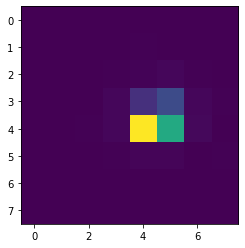

In [17]:
plt.imshow(x_train_small[15])

In [18]:
x_train_small = tf.image.central_crop(x_train, 0.2)

In [19]:
x_train_small.shape

TensorShape([100, 8, 8, 1])

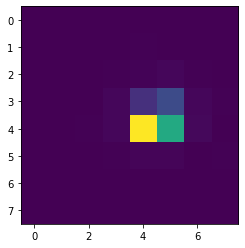

In [20]:
plt.imshow(x_train_small[15])

In [21]:
x_train.shapex_train_flattened = x_train_small.reshape(-1, x_train_small.shape[1]*x_train_small.shape[2]).T
x_train_flattened.shape

AttributeError: 
        'EagerTensor' object has no attribute 'reshape'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

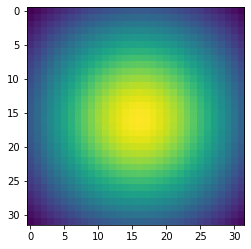

In [46]:
plt.imshow((a@a@(np.mean(x_train[:, :, :, 0], axis=0).reshape(-1,))).reshape(32,32))

In [ ]:
@njit(parallel = True)
def convolute(A,x_train):
    num_samples = len(x_train)
    for i in prange(num_samples):
        x_train

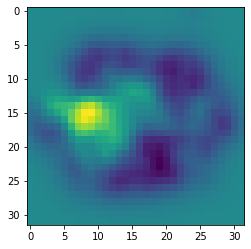

In [145]:
plt.imshow(x_train_conv[:].reshape(32,32))

In [48]:
a.shape

(1024, 1024)